## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

## Load Dataset

In [ ]:
# 데이터 로드

In [2]:
path_dir = './vehicles/vehicles/'

folder_list = os.listdir(path_dir)
file_list = {}
all_vehicles = []
for index, i in enumerate(folder_list[1:]):
    file_list[i] = os.listdir(path_dir + i)

for key in file_list.keys():
    for value in file_list[key][1:]:
        all_vehicles.append(cv2.imread(path_dir + key +'/'+ value))

In [3]:
len(all_vehicles)

8792

In [4]:
path_dir = './non-vehicles/non-vehicles/'

folder_list = os.listdir(path_dir)
file_list = {}
non_vehicles = []
for index, i in enumerate(folder_list[1:]):
    file_list[i] = os.listdir(path_dir + i)

for key in file_list.keys():
    for value in file_list[key][1:]:
        non_vehicles.append(cv2.imread(path_dir + key +'/'+ value))

In [5]:
len(non_vehicles)

8968

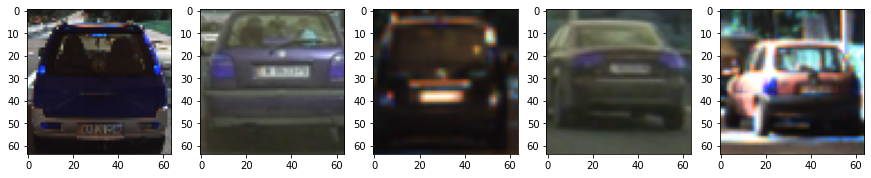

In [8]:
fig = plt.figure(figsize=(15,3))
for i in range(5):
    idx = np.random.randint(len(all_vehicles))
    img = all_vehicles[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)

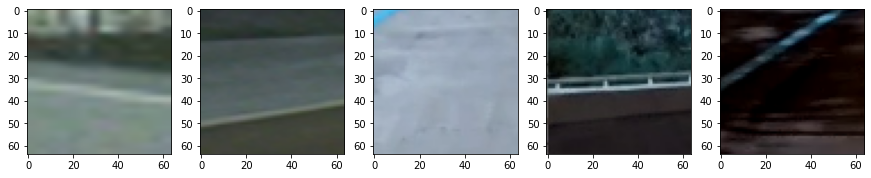

In [9]:
fig = plt.figure(figsize=(15,3))
for i in range(5):
    idx = np.random.randint(len(non_vehicles))
    img = non_vehicles[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)

In [ ]:
# 타겟 데이터 생성

In [11]:
y_vehicles = np.ones(8792).astype(int)
y_non = np.zeros(8968).astype(int)

In [12]:
x_train = np.concatenate([all_vehicles, non_vehicles], axis=0)

y_train = np.concatenate([y_vehicles, y_non], axis=0)

In [13]:
x_train.shape

(17760, 64, 64, 3)

In [14]:
len(y_train)

17760

## YCrCb로 이미지 변환

In [16]:
ycrcb = []
for img in x_train:
    ycrcb.append(cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb))
    
x_ycrcb = np.array(ycrcb)

In [17]:
x_ycrcb.shape

(17760, 64, 64, 3)

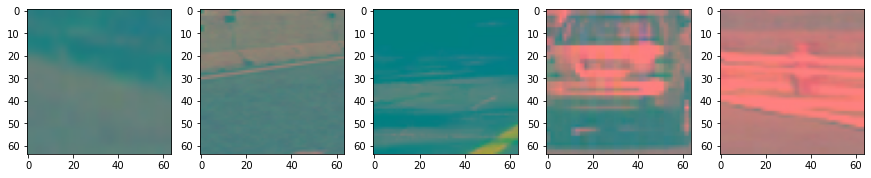

In [18]:
fig = plt.figure(figsize=(15,3))
for i in range(5):
    idx = np.random.randint(len(x_ycrcb))
    img = x_ycrcb[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)

## Feature Extraction : histogram, hog, resize 함수생성

In [ ]:
# 히스토그램 함수생성

In [13]:
def hist_(x):

    hist_flat0=[]
    for img in x:
        hist = cv2.calcHist(images=[img], channels=[0], mask=None,
                        histSize=[32], ranges=[0, 256]) 
        hist_flat0.append(hist.flatten())

    hist_flat1=[]
    for img in x:
        hist = cv2.calcHist(images=[img], channels=[1], mask=None,
                        histSize=[32], ranges=[0, 256]) 
        hist_flat1.append(hist.flatten())

    hist_flat2=[]
    for img in x:
        hist = cv2.calcHist(images=[img], channels=[2], mask=None,
                        histSize=[32], ranges=[0, 256]) 
        hist_flat2.append(hist.flatten())
        
    hist_flat0 = np.array(hist_flat0)
    hist_flat1 = np.array(hist_flat1)
    hist_flat2 = np.array(hist_flat2)
    hist_flat = np.hstack((hist_flat0, hist_flat1, hist_flat2))
        
    return hist_flat

In [14]:
x_hist = hist_(x_ycrcb)

In [15]:
x_hist.shape

(17760, 96)

In [ ]:
# hog_hsv 함수생성

In [16]:
x_ycrcb.shape

(17760, 64, 64, 3)

In [20]:
def hog_(x):
#     hsv = []
#     for img in x:
#         hsv.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    
#     x_hsv = np.array(hsv)
    
    hog_features = []
    hog_images=[]
    y, cr, cb = x[:,:,:,0], x[:,:,:,1], x[:,:,:,2]
    
    #y
    hog_features_y = []
    hog_images_y=[]
    for img in y:
        hog_feature, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                                    cells_per_block=(2,2),
                                    block_norm='L2-Hys', transform_sqrt=False,
                                    visualize=True, feature_vector=False)
        hog_features_y.append(hog_feature.flatten())
        hog_images_y.append(hog_image)
    
    #cr
    hog_features_cr = []
    hog_images_cr=[]
    for img in cr:
        hog_feature, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                                    cells_per_block=(2,2),
                                    block_norm='L2-Hys', transform_sqrt=False,
                                    visualize=True, feature_vector=False)
        hog_features_cr.append(hog_feature.flatten())
        hog_images_cr.append(hog_image)
    
    #cb
    hog_features_cb = []
    hog_images_cb =[]
    for img in cb:
        hog_feature, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                                    cells_per_block=(2,2),
                                    block_norm='L2-Hys', transform_sqrt=False,
                                    visualize=True, feature_vector=False)
        hog_features_cb.append(hog_feature.flatten())
        hog_images_cb.append(hog_image)
        
    hog_features = np.hstack((np.array(hog_features_y),np.hstack((np.array(hog_features_cr),np.array(hog_features_cb)))))
    hog_images = np.hstack((np.array(hog_images_y),np.hstack((np.array(hog_images_cr),np.array(hog_images_cb)))))
                           
    return hog_features, hog_images

In [21]:
x_hog = hog_(x_ycrcb)
x_hog_features = x_hog[0]
x_hog_images = x_hog[1]
x_hog_features.shape

(17760, 5292)

In [ ]:
# resize

In [22]:
def resize(x):
    
    resized_x = []
    for img in x:
        resized = cv2.resize(img,(32,32))
        resized_x.append(resized.flatten())
    resized_flat = np.array(resized_x)
    
    return resized_flat

In [23]:
x_resize = resize(x_ycrcb)
x_resize.shape

(17760, 3072)

## 함수변환데이터 병합 및 표준화

In [24]:
x_prepared = np.concatenate([x_hist, x_hog_features, x_resize], axis=1)
x_prepared.shape

(17760, 8460)

In [ ]:
# 표준화

In [25]:
Scaler = StandardScaler().fit(x_prepared)
x_scaled = Scaler.transform(x_prepared)

## Data Preparation

In [26]:
Xtrain, Xval, Ytrain, Yval = train_test_split(x_scaled, y_train, test_size = 0.3, stratify=y_train, random_state = 999)

In [27]:
len(Xtrain), len(Xval)

(12432, 5328)

In [28]:
Xtrain.shape

(12432, 8460)

## Classifier

In [30]:
#4 grid search

# hist(3channels) + hog(hsv) + resize(32,32) + standardscaled 

skfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=999)

# 파라미터
C = [0.01, 0.1, 1, 5]

# 파라미터 그리드
params = {'C': C}

# 교차검증
svc_grid = GridSearchCV(estimator=LinearSVC(max_iter = 10000, random_state=999), param_grid=params, cv=skfold, scoring="accuracy", n_jobs = -1)

# 모델 fitting
svc_grid.fit(Xtrain, Ytrain)

# 결과
print(svc_grid.best_score_)
print(svc_grid.best_params_)

#예측
pred = svc_grid.best_estimator_.predict(Xval)
print(roc_auc_score(Yval, pred))
print(accuracy_score(Yval, pred))

0.9913931203319206
{'C': 0.01}
0.9964244344171967
0.996433933933934


### 분류 성능 0.996

## Data Saving to Pickle

In [31]:
orient=9
pixels_per_cell=8
cells_per_block=2
spatial = 32
hist_bins = 32

In [38]:
import pickle
dist_pickle = {}
dist_pickle["svc"] = svc.best_estimator_
dist_pickle["scaler"] = Scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pixels_per_cell
dist_pickle["cell_per_block"] = cells_per_block
dist_pickle["spatial"] = spatial
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle_ycrcb.p", 'wb') )